Customer Segmentation 
-------------------
<img src=image.png style="width: 200px;"/>
- 분석에 가장 기초가 되는 transaction data 를 바탕으로, customer-level의 dimension table을 만들고, 그를 바탕으로 고객에 대해 K-means를 사용한 cluster analysis 수행한다
- clustering의 dataset이 될 customer-level table에는 아래와 같은 column들이 들어 갈 수 있다. 3번과 같은 경우 선택할 수 있는 상품이 약 2600개이므로 dimension reduction이 필요하다
    1. 상품 구매 금액, 횟수, 주기
    2. 지출 금액대 
    3. 선택한 상품

[1. Load Libraries & Dataset Exploration](#1)  
[2. Data Cleaning & Wrangling](#2)  
[- 2-1. Fact Table ](#2-1)  
[- 2-2. Customer Dimension Table](#2-2)  
[3. Dimension Reduction using PCA](#3)  
[4. Clustering](#4)  
[- 4-1. K-Means clustering](#4-1)  
[- 4-2. Model comparison](#4-2)  

<a name='1'></a>
### 1. Load Libraries & Dataset Exploration   
필요한 library와 제공된 dataset을 load하고 각 column들에 대해 간단한 통계정보를 알아본다 

In [1]:
# import libraries 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline 
import seaborn as sns 

In [2]:
# load dataset
df = pd.read_csv('data.csv')

# first 5 rows 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France


In [3]:
# dimensions 
df.shape

(35116, 8)

In [4]:
# transactions for about 9 months 
print('min invoice date:' ,df.InvoiceDate.min())
print('max invoice date:' ,df.InvoiceDate.max())

min invoice date: 1/10/11 10:35
max invoice date: 9/9/11 9:13


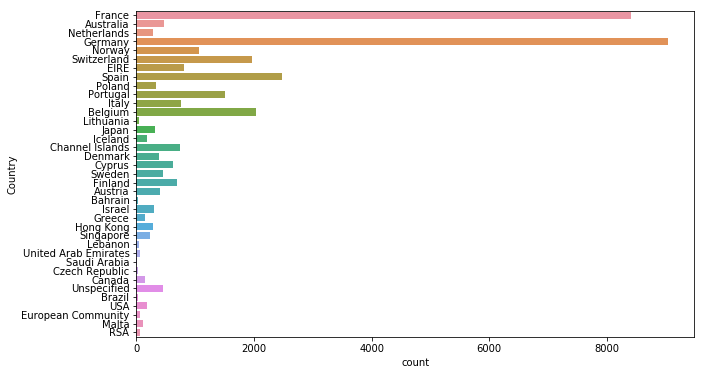

In [5]:
# Country distribution on dataset
plt.figure(figsize=(10, 6))
sns.countplot(y='Country', data=df)

In [6]:
# the number of items 
print('# of items: ', df.StockCode.nunique())

# the number of customers 
print('# of customers: ', df.CustomerID.nunique())

# the number of orders(invoice)
print('# of orders: ', df.InvoiceNo.nunique())

# of items:  2602
# of customers:  414
# of orders:  1591


<a name='2'></a>
### 2. Data Cleaning & Wrangling 
- 주어진 데이터가 transaction 기준(한 row에 하나의 주문 번호, 상품번호, 구매 갯수, 고객번호)이므로 고객이 구매한 상품을 기준으로 clustering 하려면 transaction-level -> customer-level로 테이블을 변형해야 한다.
- transaction-level을 fact table이라고 하고 customer-level을 customer dimension table이라고 하자.
<a name='2-1'></a>
#### 2-1. fact table (transactions-level)

In [7]:
# nan data 
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

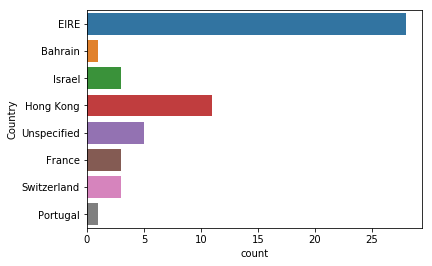

In [8]:
# 고객ID 1400개 정도 nan 
# 어느 나라에서 주문한 거래에 가장 많이 nan 이 있는지 그래프로 알아봄
sns.countplot(y='Country', data=df[df.CustomerID.isnull()].drop_duplicates('InvoiceNo'))

아일랜드(EIRE)에서 nan 고객이 가장 많았고 나머지는 여러 나라에 분산 되어 있다. 고객을 분류하는것이므로 고객ID가 없으면 무의미하기 때문에, 아래와 같은 방안을 생각 해 볼 수 있다.
1. `dropna()` -> 데이터 손실 
2. 주문건1개당 하나의 고객으로 보고 `fillna()` -> 55명이 추가됨 (`df.drop_duplicates('InvoiceNo').isnull().sum().loc['CustomerID']`==55). 현재는 주문건 1540개에 고객이 414명 -> 주문건 1590개에 고객 460개면 대략적인 주문건수 대비 고객수의 비율은 크게 변하지 않는다. 

문제를 간단히 하기위하여 일단 1번 방식으로 null값을 제거한다.

In [9]:
df = df[df.CustomerID.notnull()]

In [10]:
# column data types 
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Turning 'CustomerID' & 'InvoiceDate' into int and datetime, respectively.

In [11]:
df['CustomerID'] = df.CustomerID.astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
# add sales feature 
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [13]:
# save transaction-level data
# df.to_csv('transactions.csv', index=None)

<a name='2-2'></a>
#### 2-2. customer dimension table (customer-level)
transaction 데이터를 고객 중심으로 본다면, customer-level 테이블에서 아래와 같은 feature를 만들 수 있다.
- 고객별 주문 횟수
- 고객별 상품 주문 수, SKU 주문 수
- 고객별 매출 총합, 평균
- 고객별 basket size 최소, 최대, 평균 

In [14]:
# 고객별 주문 횟수 
invoice_by_customer = (df.groupby('CustomerID')[['InvoiceNo']]
                .nunique()
                .rename(columns={'InvoiceNo':'total_txs'}))

In [15]:
invoice_by_customer.head()

,total_txs
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [16]:
# 고객별 주문 상품수 (전체 주문 상품수 & 주문 SKU순)
prod_by_customer = (df.groupby('CustomerID')
                   ['StockCode'].agg({'total_skus':'nunique',
                                     'total_prods':'count'}))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [17]:
prod_by_customer.head()

,total_skus,total_prods
CustomerID,,
12347,103,182
12348,22,31
12349,73,73
12350,17,17
12352,59,85


In [18]:
# 고객별 매출 
sales_by_customer = (df.groupby('CustomerID')['Sales']
                    .agg({'total_sales': 'sum', 
                         'avg_prod_value': 'mean'}))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [19]:
sales_by_customer.head()

,total_sales,avg_prod_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


In [20]:
# 고객별 basket size (한번 주문할때 그 금액)
bs_df = (df.groupby(['CustomerID', 'InvoiceNo'])[['Sales']]
                 .sum().rename(columns={'Sales':'basket_size'}))
bs_df.reset_index(inplace=True)

In [21]:
bs_df.head()

,CustomerID,InvoiceNo,basket_size
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


In [22]:
bs_by_customer = (bs_df.groupby('CustomerID')['basket_size']
                  .agg({'avg_bs':np.average,
                       'min_bs': np.min,
                       'max_bs': np.max}))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [23]:
# customer dimension dataframe 
# 고객별 주문 횟수 + 매출 + basket size 
customer_dim_df = invoice_by_customer.join([prod_by_customer, 
                                           sales_by_customer, 
                                           bs_by_customer])

fact table (transaction-level)에서 customer dimension table로 변형

In [24]:
# customer-level table 
customer_dim_df.head()

,total_txs,total_skus,total_prods,total_sales,avg_prod_value,avg_bs,min_bs,max_bs
CustomerID,,,,,,,,
12347,7,103,182,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,22,31,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,59,85,2506.04,29.482824,313.255000,120.33,840.30


In [25]:
# customer-level table dimension
customer_dim_df.shape

(414, 8)

<a name='3'></a>
#### 3. Dimension Reduction using PCA

[2-2. Customer Dimension Table](#2-2)에서 customer-level에 일반적으로 고객을 평가 할 수 있는 feature를 만들었다. 이에 더해 고객들이 어떤 상품을 샀는지를 바탕으로 cluster하기 위해서, 우선 상품 하나하나가 column이 되도록 one-hot encoding을 한다. 상품이 2600개 정도 되기 때문에 `PCA()`를 이용해서, total variance를  잘 설명할 수 있는 주 성분만 뽑는다 -> 차원 축소.
- 상품에 대해 one-hot encoding
- `StandardScaler()`로 feature value 스케일 조정
- `PCA()`로 explained variance가 높은 feature만 뽑아옴 

In [26]:
# Get dataset one hot encoded by 'StockCode'
items_one_hot = pd.get_dummies(df.StockCode)
items_one_hot['CustomerID'] = df['CustomerID']

# Group transaction-level data by 'CustomerID'
items_one_hot = items_one_hot.groupby('CustomerID').sum()

In [27]:
items_one_hot.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5


In [28]:
# item_one_hot table dimension 
items_one_hot.shape

(414, 2574)

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [30]:
# StandardScaler instance initialization
scaler = StandardScaler()
items_one_hot_scaled = scaler.fit_transform(items_one_hot)

In [31]:
# PCA instance initialization
pca  = PCA()
pca.fit(items_one_hot_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

별도의 parameter를 넣지 않았을때, `n_components` = min(# features, # samples)이므로 414개의 components가 새로 생성

In [32]:
# Generate new features to replace StockCode features 
new_features = pca.transform(items_one_hot_scaled)

In [33]:
# Cumulative sum of explained variance of each feature 
cumsum_explained_var = np.cumsum(pca.explained_variance_ratio_)

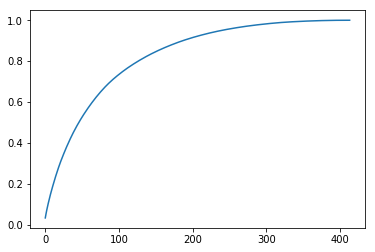

In [34]:
plt.plot(range(len(cumsum_explained_var)), cumsum_explained_var)

- 위의 그래프를 보면 알 수 있듯이 `n_components`가 200일때, `cumsum_explained_var`가 90%정도 됨
- 200개의 components만 생성하도록 다시 PCA instance를 만들 수 있다

In [35]:
# 200 components can capture 90% of the total variances
cumsum_explained_var[200]

0.91544629459845894

In [36]:
# PCA instance initialization
pca = PCA(n_components=200)
# fit & transform altogether 
new_features = pca.fit_transform(items_one_hot_scaled)

In [37]:
new_features.shape

(414, 200)

In [38]:
# Make dataframe out of new components 
new_features_df = pd.DataFrame(new_features)
new_features_df.index = items_one_hot.index
new_features_df.columns = ['feature_{}'.format(i+1) for i in range(new_features.shape[1])]

In [39]:
new_features_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,5.876140,4.828917,-0.495545,3.093850,-0.633706,-11.534092,2.161994,7.116958,5.336009,4.424413,...,0.101096,0.071295,-0.043670,-0.170613,-0.229699,-0.054639,-0.136906,0.015912,0.265877,-0.104087
12348,-4.219838,1.226216,-1.881911,-0.174333,0.818010,1.160824,-0.871665,-0.846627,0.460267,0.854257,...,-4.642472,0.148534,-0.936091,-0.587967,-0.710809,-2.152867,-1.871024,-2.920844,-0.987518,-2.622857
12349,-1.260847,2.387666,-0.073146,-1.119167,-0.034344,-3.715398,-0.343609,-0.149039,-0.789987,-0.379256,...,-0.831464,-1.732610,-1.933065,2.365349,0.727633,-0.243169,0.054962,-0.685623,-1.488934,-2.627554
12350,-4.929320,-0.714853,-1.580934,-0.469773,-0.116292,0.647827,0.112913,-1.336308,1.547067,-1.190457,...,-1.578131,0.313718,-0.566066,-1.511823,-1.296952,2.208884,-0.972071,-0.727725,0.678144,-0.611263
12352,-2.053113,2.110949,0.184807,0.128242,0.087788,-1.943580,2.383306,0.899606,-0.671971,0.081461,...,0.486429,2.064384,0.377593,0.843647,-2.151884,-1.604314,-0.516667,0.666850,-0.333279,1.747221


<a name='4'></a>
#### 4. Cluster Analysis 
cluster analysis를 수행 할 때, 앞서 만든 dataset두가지를 넣어 볼 수 있다.
- 1. `customer_dim_df`
- 2. `customer_dim_df`+`new_features`

clustering의 경우 unsupervised learning으로 알고리즘의 performance를 측정할 metric이 정의되어있지 않기 때문에, 서로 다른 데이터셋이나 알고리즘으로 나온 cluster결과를 비교해서 그 결과가 얼마나 비슷한지/다른지를 알아본다. 

K-Means clustering에서 K는 일단 임의로 4개로 정한다
<a name='4-1'></a>
#### 4-1. K-Means clustering

In [40]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [41]:
#1. customer dimension
customer_dim_df.head()

,total_txs,total_skus,total_prods,total_sales,avg_prod_value,avg_bs,min_bs,max_bs
CustomerID,,,,,,,,
12347,7,103,182,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,22,31,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,59,85,2506.04,29.482824,313.255000,120.33,840.30


In [42]:
k_means_1 = make_pipeline(StandardScaler(), KMeans(n_clusters=4))
k_means_1.fit(customer_dim_df)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [43]:
customer_dim_df['cluster'] = k_means_1.predict(customer_dim_df)

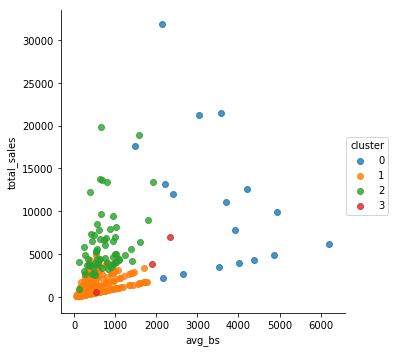

In [44]:
# clusters in plot 
sns.lmplot(x='avg_bs', y='total_sales', hue='cluster',
           data=customer_dim_df, fit_reg=False)

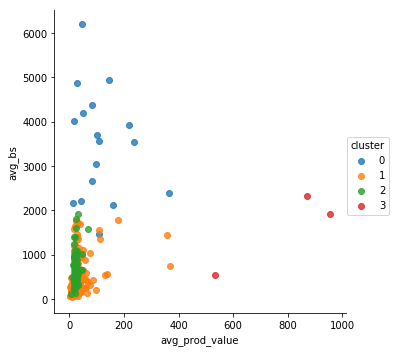

In [45]:
# clusters in plot 
sns.lmplot(x='avg_prod_value', y='avg_bs', hue='cluster',
           data=customer_dim_df, fit_reg=False)

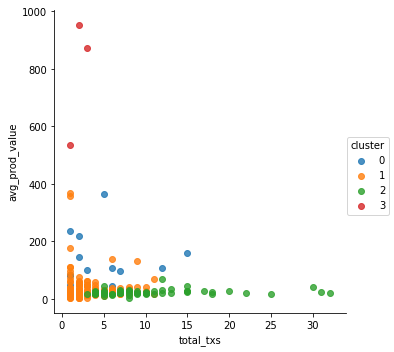

In [46]:
# clusters in plot 
sns.lmplot(x='total_txs', y='avg_prod_value', hue='cluster',
           data=customer_dim_df, fit_reg=False)

- 0번 cluster의 경우 거의 나타나지 않음
- 1번 cluster: 한번 시킬때 basket size는 적지만 자주 구매
- 2번 cluster: basket size도 적고 구매도 단일성 (가장 많은 고객들이 이 그룹에 속함)
- 3번 cluster: basket size가 높은 경우 

In [47]:
# 2. customer dimension + newly generated features 
new_customer_dim_df = customer_dim_df.join(new_features_df)
new_customer_dim_df.head()

,total_txs,total_skus,total_prods,total_sales,avg_prod_value,avg_bs,min_bs,max_bs,cluster,feature_1,...,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,103,182,4310.00,23.681319,615.714286,224.82,1294.32,2,5.876140,...,0.101096,0.071295,-0.043670,-0.170613,-0.229699,-0.054639,-0.136906,0.015912,0.265877,-0.104087
12348,4,22,31,1797.24,57.975484,449.310000,227.44,892.80,1,-4.219838,...,-4.642472,0.148534,-0.936091,-0.587967,-0.710809,-2.152867,-1.871024,-2.920844,-0.987518,-2.622857
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,1,-1.260847,...,-0.831464,-1.732610,-1.933065,2.365349,0.727633,-0.243169,0.054962,-0.685623,-1.488934,-2.627554
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,1,-4.929320,...,-1.578131,0.313718,-0.566066,-1.511823,-1.296952,2.208884,-0.972071,-0.727725,0.678144,-0.611263
12352,8,59,85,2506.04,29.482824,313.255000,120.33,840.30,1,-2.053113,...,0.486429,2.064384,0.377593,0.843647,-2.151884,-1.604314,-0.516667,0.666850,-0.333279,1.747221


In [48]:
k_means_2 = make_pipeline(StandardScaler(), KMeans(n_clusters=4))
k_means_2.fit(new_customer_dim_df)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [49]:
new_customer_dim_df['cluster'] = k_means_2.predict(new_customer_dim_df)

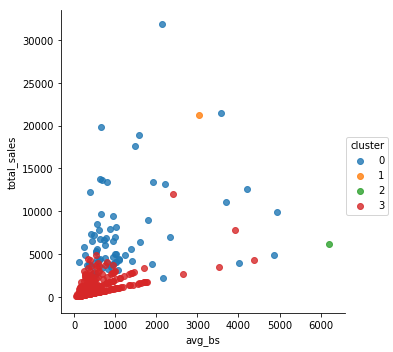

In [50]:
# clusters in plot 
sns.lmplot(x='avg_bs', y='total_sales', hue='cluster',
           data=new_customer_dim_df, fit_reg=False)

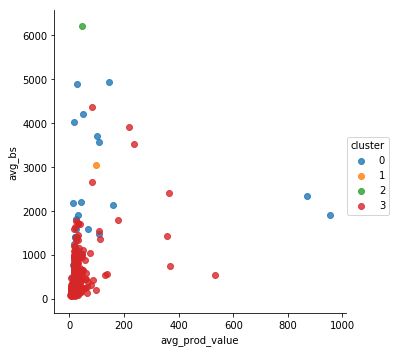

In [51]:
# clusters in plot 
sns.lmplot(x='avg_prod_value', y='avg_bs', hue='cluster',
           data=new_customer_dim_df, fit_reg=False)

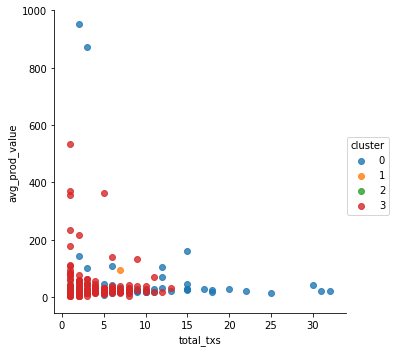

In [52]:
# clusters in plot 
sns.lmplot(x='total_txs', y='avg_prod_value', hue='cluster',
           data=new_customer_dim_df, fit_reg=False)

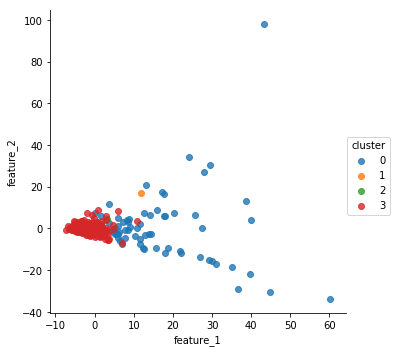

In [53]:
# clusters in plot 
sns.lmplot(x='feature_1', y='feature_2', hue='cluster',
           data=new_customer_dim_df, fit_reg=False)

- 0, 2번 cluster의 경우 거의 나타나지 않음
- 1번 cluster: basket size가 높거나, total sales가 높은 경우 
- 3번 cluster: 둘 다 낮은 경우 (저렴한거 한 두어번 사고 재구매 하지 않는 경우)

<a name='4-2'></a>
#### 4-2. Model Comparison

In [54]:
from sklearn.metrics import adjusted_rand_score

In [55]:
# rand index 
adjusted_rand_score(new_customer_dim_df['cluster'], customer_dim_df['cluster'])

0.84068049389131505

다른 두 데이터 셋으로 클러스터링 했을 때, 그 결과는 67%정도 비슷하다.